In [1]:
import os
import sys
import time
import math
import h5py
import numpy as np
from datetime import datetime, timedelta

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import vae_utils as vu
import model_utils as mu

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return (x-50)/28/2

def norm_t(x):
    return (x-281)/10/2

def norm_u(x):
    return (x-3.5)/6.5/2

def norm_v(x):
    return (x)/6.5/2

def norm_pwat(x):
    return (x-20.5)/15/2

def norm_cape(x):
    return (x-200)/450/2

In [29]:
year = 2022
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=d) for d in range(365)]

N_start = 0

LEADs = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] #
INIs = [0, 6, 12, 18]

gapx = 7
gapy = 12

# size = 128 # patch size: 128-by-128
# gap = 24 # subset patches with gaps of 24 grids
# N_rain_thres = 1600 # each patch must have 1600 raining grid cells
# V_rain_thres = 0.1 # 0.1 mm/3h means rain

BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/'
batch_file_name = 'diffusion_y{:04d}_ini{:02d}_lead{:02d}_dt{:04d}.npy'

In [27]:
256-242

14

In [7]:
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_GFS = h5io['lon_GFS'][...]
    lat_GFS = h5io['lat_GFS'][...]
    elev_GFS = h5io['elev_GFS'][...]

# ------- normalized elevation ----- #
elev_GFS[elev_GFS<0] = 0
elev_GFS = elev_GFS/2000 - 1

# data size info
size_x = 128; size_y = 256
x_gfs = 105; y_gfs = 242 # 0.25 deg GFS size

grid_shape = (size_x, size_y)

# ------- Import MRMS data ------- #
with h5py.File('/glade/campaign/cisl/aiml/ksha/GFS/MRMS_01H_y{}_025.hdf'.format(year), 'r') as h5io:
    MRMS_base = h5io['MRMS'][...]
L_base = len(MRMS_base)

# forecast lead times can exceed one year
N_beyond = 5*24
N_total = L_base + N_beyond
with h5py.File('/glade/campaign/cisl/aiml/ksha/GFS/MRMS_01H_y{}_025.hdf'.format(year+1), 'r') as h5io:
    MRMS_extra = h5io['MRMS'][:N_beyond, ...]

MRMS = np.concatenate((MRMS_base, MRMS_extra), axis=0)

In [30]:
name_gfs = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_{}_ini{:02d}_f{:02d}.hdf'
name_apcp = '/glade/campaign/cisl/aiml/ksha/GFS/GFS_APCP_{}_ini{:02d}_f{:02d}.hdf'

# data allocations
data = np.empty((1, size_x, size_y, 9))
data[...] = 0.0

gfs = np.empty((1, x_gfs, y_gfs, 7))
gfs[...] = np.nan

for lead in LEADs:
    for ini in INIs:

        with h5py.File(name_gfs.format(year, ini, lead), 'r') as h5io:
            CAPE = h5io['CAPE'][...]
            PWAT = h5io['PWAT'][...]
            T800 = h5io['T800'][...]
            U800 = h5io['U800'][...]
            V800 = h5io['V800'][...]
            RH800 = h5io['RH800'][...]
        
        with h5py.File(name_apcp.format(year, ini, lead), 'r') as h5io:
            APCP = h5io['APCP'][...]

        # ======================================================== #
        for i_dt, dt in enumerate(date_list):

            # N_start = 0 means full run
            # N_start = 363 for small tests
            if i_dt >= N_start:
                
                # get the forecasted hour (ini + lead)
                N_hours = i_dt*24 + ini + lead
                
                # combine hourly MRMS to 3-hr accumulated values
                if N_hours < N_total:
                    MRMS_temp = MRMS[N_hours, ...] + MRMS[N_hours-1, ...] + MRMS[N_hours-2, ...]
                    
                    # if MRMS has no NaNs
                    if np.sum(np.isnan(MRMS_temp)) == 0:
                        
                        gfs[..., 0] = APCP[i_dt, ...]
                        gfs[..., 1] = CAPE[i_dt, ...]
                        gfs[..., 2] = PWAT[i_dt, ...]
                        gfs[..., 3] = T800[i_dt, ...]
                        gfs[..., 4] = U800[i_dt, ...]
                        gfs[..., 5] = V800[i_dt, ...]
                        gfs[..., 6] = RH800[i_dt, ...]
        
                        # collect batch data
                        # index 0: MRMS target
                        data[:, gapy:x_gfs+gapy, gapx:y_gfs+gapx, 0] = MRMS_temp
                        data[:, gapy:x_gfs+gapy, gapx:y_gfs+gapx, 1:8] = gfs
                        data[:, gapy:x_gfs+gapy, gapx:y_gfs+gapx, 8] = elev_GFS # normalized elevatino
                        
                        # convert negative MRMS to zero
                        # 
                        temp = data[..., 0]
                        temp[temp < 0] = 0
                        data[..., 0] = temp
        
                        # data normalization
                        data[..., 0] = norm_precip(data[..., 0]) # MRMS
                        data[..., 1] = norm_precip(data[..., 1]) # GFS APCCP
                        data[..., 2] = norm_cape(data[..., 2]) # GFS CAPE
                        data[..., 3] = norm_pwat(data[..., 3]) # PWAT
                        data[..., 4] = norm_t(data[..., 4]) # T800
                        data[..., 5] = norm_u(data[..., 5]) # U800
                        data[..., 6] = norm_v(data[..., 6]) # V800
                        data[..., 7] = norm_rh(data[..., 7]) # RH800
 
                        flag_nan = np.sum(np.isnan(data))
                        flag_zero = np.sum(data[..., 0] > 0)
                        
                        if flag_nan == 0 and flag_zero > 0:
                        
                            data_save = {}
                            data_save['GFS'] = data[..., 1:]
                            data_save['MRMS'] = data[..., 0][..., None]
    
                            # save as .npy
                            name_ = BATCH_dir+batch_file_name.format(year, ini, lead, N_hours)
                            print(name_)
                            np.save(name_, data_save)

/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0003.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0027.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0051.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0075.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0099.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0123.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0147.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0171.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0195.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0219.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini00_lead03_dt0243.npy
/glade/campaign/cisl/aiml/ksha/BATCH_LDM_025/diffusion_y2022_ini0


KeyboardInterrupt



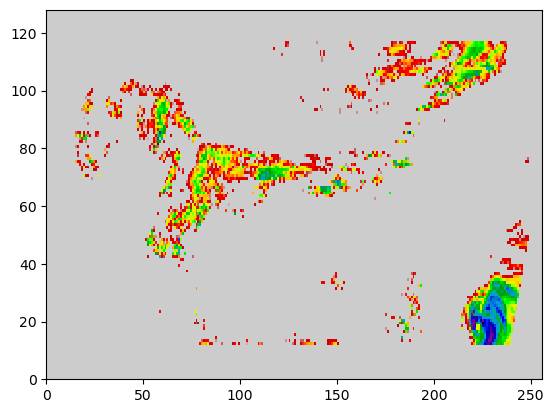

In [32]:
plt.pcolormesh(data[0, ..., 0], cmap=plt.cm.nipy_spectral_r)

(0.0, 128.0)

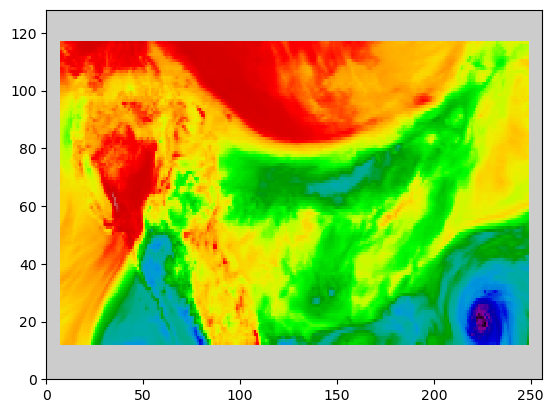

In [31]:
plt.pcolormesh(data[0, ..., 3], cmap=plt.cm.nipy_spectral_r)
plt.xlim([0, 256])
plt.ylim([0, 128])

In [16]:
temp_data = np.load(
    '/glade/campaign/cisl/aiml/ksha/BATCH_LDM/diffusion_y2022_ini12_lead03_dt8751_ix120_iy432.npy', 
    allow_pickle=True)[()]